In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Parkinson Dataset.zip to Parkinson Dataset.zip


In [ ]:
import zipfile
with zipfile.ZipFile("Parkinson Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_folder")


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage.filters import gabor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
BASE_PATH = "/content/dataset_folder/Parkinson Dataset/dataset/spiral"

In [ ]:
PATHS = {
    "train_healthy": os.path.join(BASE_PATH, "training", "healthy"),
    "train_parkinson": os.path.join(BASE_PATH, "training", "parkinson"),
    "test_healthy": os.path.join(BASE_PATH, "testing", "healthy"),
    "test_parkinson": os.path.join(BASE_PATH, "testing", "parkinson")
}

In [ ]:
print("Verifying folder structure...")
for name, path in PATHS.items():
    print(f"{name:15}: {len(os.listdir(path))} images found")

Verifying folder structure...
train_healthy  : 36 images found
train_parkinson: 36 images found
test_healthy   : 15 images found
test_parkinson : 15 images found


In [ ]:
def load_images(folder_path, label, img_size=64):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {os.path.basename(folder_path)}"):
        if filename.lower().endswith('.png'):
            img = imread(os.path.join(folder_path, filename), as_gray=True)
            img = resize(img, (img_size, img_size), anti_aliasing=True)
            images.append(img.flatten())
            labels.append(label)
    return np.array(images), np.array(labels)

print("\nLoading training data...")
X_train_healthy, y_train_healthy = load_images(PATHS["train_healthy"], 0)
X_train_parkinson, y_train_parkinson = load_images(PATHS["train_parkinson"], 1)

print("\nLoading testing data...")
X_test_healthy, y_test_healthy = load_images(PATHS["test_healthy"], 0)
X_test_parkinson, y_test_parkinson = load_images(PATHS["test_parkinson"], 1)

# Combine and check dataset sizes
X_train = np.concatenate((X_train_healthy, X_train_parkinson))
y_train = np.concatenate((y_train_healthy, y_train_parkinson))
X_test = np.concatenate((X_test_healthy, X_test_parkinson))
y_test = np.concatenate((y_test_healthy, y_test_parkinson))

print(f"\nFinal dataset sizes:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")



Loading training data...


Loading parkinson: 100%|██████████| 36/36 [00:00<00:00, 228.73it/s]



Loading testing data...


Loading parkinson: 100%|██████████| 15/15 [00:00<00:00, 218.47it/s]


Final dataset sizes:
Training: 72 samples
Testing: 30 samples


In [ ]:
from sklearn.utils import resample
def augment_data(X, y, multiplier=2):
    """Simple duplication with slight noise"""
    X_aug = np.repeat(X, multiplier, axis=0)
    y_aug = np.repeat(y, multiplier)
    noise = np.random.normal(0, 0.01, X_aug.shape)  # Small Gaussian noise
    return X_aug + noise, y_aug

if X_train.shape[0] < 100:  # Only augment if dataset is small
    X_train, y_train = augment_data(X_train, y_train)
    print(f"After augmentation: {X_train.shape[0]} training samples")

# Optimized Random Forest with class balancing
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Crucial for imbalanced data
    n_jobs=-1,
    random_state=42
)

After augmentation: 144 training samples


In [ ]:
print("\nTraining model...")
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson's"]))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.2%}")


Training model...

Model Accuracy: 83.33%

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.81      0.87      0.84        15
 Parkinson's       0.86      0.80      0.83        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

AUC-ROC Score: 93.78%



Most important pixel positions: [ 401 1984 2460 1346 3599]


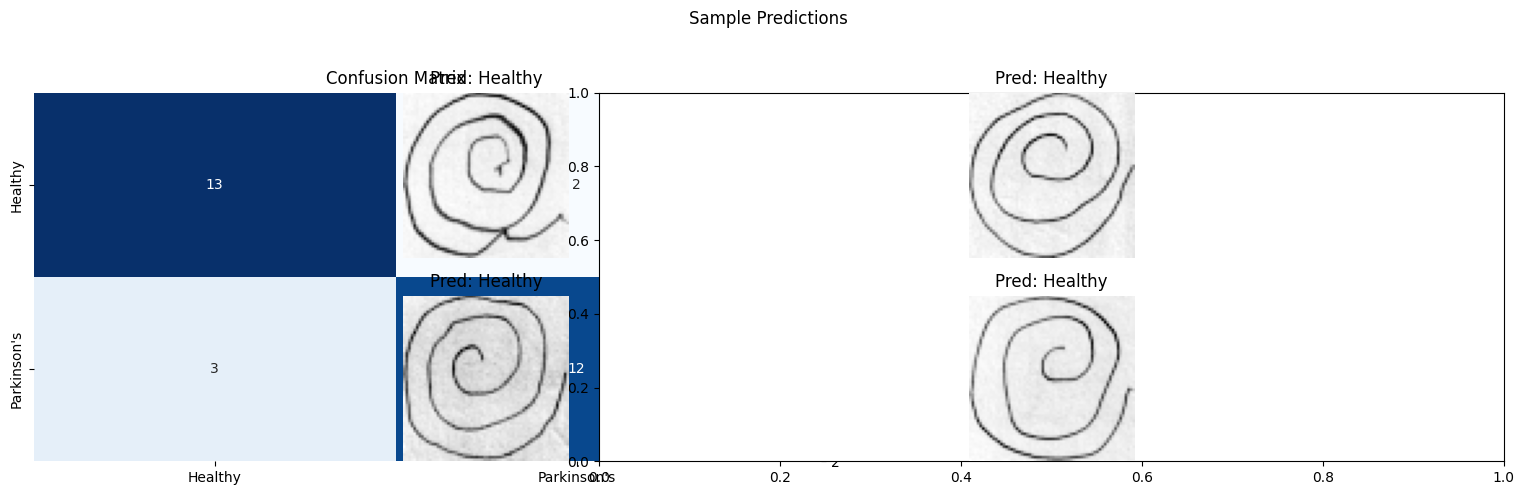

In [ ]:
importances = model.feature_importances_
important_pixels = np.argsort(importances)[-5:]  # Top 5 important pixels
print("\nMost important pixel positions:", important_pixels)

# Enhanced visualization
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Parkinson's"],
            yticklabels=["Healthy", "Parkinson's"])
plt.title("Confusion Matrix")

# Sample images with predictions
plt.subplot(1, 2, 2)
sample_idx = np.random.choice(len(X_test), 4, replace=False)
for i, idx in enumerate(sample_idx):
    img = X_test[idx].reshape(64, 64)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {'Parkinson' if y_pred[idx] else 'Healthy'}")
    plt.axis('off')
plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()

In [ ]:

import joblib

# Save the model to a file
joblib.dump(model, "parkinson_rf_model.pkl")

# Download the model to your local system
from google.colab import files
files.download("parkinson_rf_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>